# Between Space + Use

Karen Zellner 10.2016

### Project Scope: Space Planning & Optimized Facility Use 
* Problem: Space programming is the process of identifying the spatial/operational needs of a building or campus. Before any architectural projects can happen there needs to be a rigorous analysis of existing conditions and processes, as well as a clearly defined scope of work. In addition to looking for advice on specific modifications/additions to their facilities, clients often need an objective review of their current utilization patterns and scheduling procedures. My goal is to take on one such project and use machine learning to assist in the space planning analysis of a university's existing science facilities and teaching labs.  This project will:

     - Step 1: Identify and sort through existing spaces and rooms. Observe patterns in usage. 
     - Step 2: Identify strong combinations of rooms that fit into existing buildings. Value determined by cost and usability.
     - Step 3: Create future scenarios for course/department growth. Identify the timeline of use for a building based on the top options. 
    

* Potential models I explored in the begining were the bin packing problem (optimization for bins) and the knapsack problem (optimization of 'value'). The issue I ran into was that due to the existing conditions that define the bins or knapsacks this became an incredibly tedious task that far exceeded my python skills. If this was a new facility perhaps this would have been a better option.


* Impact: Programming involves parsing through large amounts of data to create scope for a project. Unfortunately this is very time intensive, and doesn't directly lead to being awarded the design/construction project. The impact to turn these around faster would allow designers to quickly prepare these studies with high levels of accuracy/certainty. Data influenced design. 


### Dictionary

Variable | Description 
---| ---
RmType | TeachingLabXL, TeachingLabLg, TeachingLabMed, TeachingLabSm, TeachingLabAdLg, TeachingLabAd, Seminar, LectureXL, LectureMed, LectureLg, AuditoriumLg, Auditorium
Technical | 0: No, 1: Yes, 2: Advanced 
Term | Autumn 2013, Winter 2014, Spring 2014, Autumn 2014, Winter 2015, Spring 2015, Autumn 2015, Winter 2016, Spring 2016 
Building | Campus Buildings C: Cobb Lecture Hall, J: George Herbert Jones Lab, HGS: Hinds Geophysical Science, K: Kent, KPTC: Kersten Physics Teaching Center
Subject | MATH, NTSC, PHSC, PHYS, SOSC, ECON, ENGL, GEOS, FNDL, INST, STAT, CHEM, STCH, PSYC, PPHA, PLSC, PHIL, PBPL, NTSC, NEHC, MEND, MAPS, MAPH, LACS, IME, HUMA, HIST, HIPS, FINM, EALC, CMSC, CAAP, BPRO, ASTR, ARAB, ANTH 
CourseName | Dept + Course Number 
Section | Number 
MeetingType | DIS, EVT, LAB, LEC, SEMINAR, TUTORIAL 
DaysMet | ARR, M, MF, MTWRF, MW, MWF, R, T, TR, W, WF (Needs to be recatagorized per day of the week)
DaysWK| Number 
Duration | Class Length 
HoursPerWeek | Time 
Enrollment | Number of students 
RmID | Room Number  
SeatCapacity | Number of students/Number availible seats 
RmCapacity | Registrar's Room Capacity, aka # of seats
SF | Square Feet Area  
TargetUtilization | Target number of hours to be scheduled per week




## Data : *Importing, Cleaning and Formatting*

In [33]:
%matplotlib inline

from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import pylab as pl
import seaborn as sns
import binpacker 
import math

In [34]:
# Room Inventory Data 
data_RI = pd.read_csv("RI-2.csv")
#data_RI = data_RI.dropna()

#Description
print "Room Inventory Description:", data_RI.shape
print data_RI.dtypes
print "Number of Rooms:", len(data_RI['RmID'].unique())
print "Types of Rooms:", len(data_RI['RmType'].unique()), data_RI['RmType'].unique()
data_RI['count'] = 1
print data_RI.tail()
print data_RI.groupby('RmType').sum()

Room Inventory Description: (71, 7)
Building             object
RmID                 object
RmType               object
TargetUtilization     int64
RmCapacity            int64
SF                    int64
Tech                  int64
dtype: object
Number of Rooms: 71
Types of Rooms: 11 ['Auditorium' 'AuditoriumLg' 'LectureLg' 'LectureMed' 'LectureXL' 'Seminar'
 'TeachingLabAdLg' 'TeachingLabLg' 'TeachingLabMed' 'TeachingLabSm'
 'TeachingLabXL']
   Building     RmID         RmType  TargetUtilization  RmCapacity    SF  \
66      HGS  HGS 430  TeachingLabXL                 28          40  1800   
67        K    K 202  TeachingLabXL                 28          40  1800   
68        K    K 212  TeachingLabXL                 28          40  1800   
69        K    K 302  TeachingLabXL                 28          40  1800   
70        K    K 312  TeachingLabXL                 28          40  1800   

    Tech  count  
66     1      1  
67     1      1  
68     1      1  
69     1      1  
70    

In [35]:
# Class Inventory Data 
data_CI = pd.read_csv("CI.csv")
#data_CI = data_CI.dropna()

#Description
print data_CI.dtypes
print "Class Inventory Description:", data_CI.shape
print "Number of Classes:", len(data_CI) #courses do not have unique id... you can only figure it out by course by semester
numsemester = len(data_CI['Term'].unique())
print "Number of Semesters:", len(data_CI['Term'].unique())

# Notes: At first I had tried dropping na, but there were way way too many blanks. I ended up manually 
    # sorting through some of the data that was incomplete. While doing that I split out event entries. 

RmType           object
Technical         int64
Term             object
Subject          object
CourseName       object
Section          object
DaysMet          object
DaysWK            int64
Duration        float64
HoursPerWeek    float64
Building         object
RmID             object
Enrollment        int64
SeatCapacity    float64
dtype: object
Class Inventory Description: (2239, 14)
Number of Classes: 2239
Number of Semesters: 9


In [36]:
# Split Class Data into Semesters
data_CI.sort_values(by=['Term'], inplace=True) # sort the dataframe
data_CI.set_index(keys=['Term'], drop=False,inplace=True) # set the index to be this and don't drop
Terms = data_CI['Term'].unique().tolist() # get a list of the semesters

# Creates new dataframes for each semester
A2013 = data_CI.loc[data_CI.Term == '2013-3Fall']
W2014 = data_CI.loc[data_CI.Term == '2014-1Winter']
S2014 = data_CI.loc[data_CI.Term == '2014-2Spring']
A2014 = data_CI.loc[data_CI.Term == '2014-3Fall']
W2015 = data_CI.loc[data_CI.Term == '2015-1Winter']
S2015 = data_CI.loc[data_CI.Term == '2015-2Spring']
A2015 = data_CI.loc[data_CI.Term == '2015-3Fall']
W2016 = data_CI.loc[data_CI.Term == '2016-1Winter']
S2016 = data_CI.loc[data_CI.Term == '2016-2Spring']

print W2015.head()

#Notes: I really struggled getting the semesters to be chrnonological. Eventually I ended up
    # manually changing the names so they would self order. In the future I would want to be
    # able to specify order. 

                      RmType  Technical          Term Subject  CourseName  \
Term                                                                        
2015-1Winter  Teaching LabSm          1  2015-1Winter    CHEM  CHEM 11200   
2015-1Winter  Teaching LabSm          1  2015-1Winter    CHEM  CHEM 11200   
2015-1Winter  Teaching LabSm          1  2015-1Winter    CHEM  CHEM 11200   
2015-1Winter  Teaching LabSm          1  2015-1Winter    CHEM  CHEM 11200   
2015-1Winter  Teaching LabSm          1  2015-1Winter    CHEM  CHEM 11200   

             Section DaysMet  DaysWK  Duration  HoursPerWeek Building   RmID  \
Term                                                                           
2015-1Winter     NaN       W       1       4.0           4.0        K  K 202   
2015-1Winter     NaN       M       1       4.0           4.0        K  K 212   
2015-1Winter     NaN       M       1       4.0           4.0        K  K 211   
2015-1Winter     NaN       R       1       4.0           4.0

In [37]:
# Gets average utilization of seats in room
def avgseatsused(seats):
   return seats['SeatCapacity'].mean()

seats = data_CI.groupby(['RmID']).apply(avgseatsused)
seats = pd.DataFrame(seats)
seats.columns = ['AvgSeatsFilled']
data_RI2 = data_RI.join(seats, how='inner', on='RmID' , sort=False)
#data_RI['AvgSeatsFilled']=data_RI['AvgSeatsFilled']* data_RI['RmCapacity']
data_RI2.tail()

,Building,RmID,RmType,TargetUtilization,RmCapacity,SF,Tech,count,AvgSeatsFilled
66,HGS,HGS 430,TeachingLabXL,28,40,1800,1,1,0.820588
67,K,K 202,TeachingLabXL,28,40,1800,1,1,1.000800
68,K,K 212,TeachingLabXL,28,40,1800,1,1,0.907111
69,K,K 302,TeachingLabXL,28,40,1800,1,1,0.790667
70,K,K 312,TeachingLabXL,28,40,1800,1,1,0.626111


In [86]:
# Gets weekly room use for each classroom per semester

#What this needs to do:
    # For each semester it needs to count the total hours the room is in use 
    # Then it needs to add this information to the data_RI dataframe matching for each RmID- one column per semester
    # From this we can calculate if it is hitting target utilization 
            # As defined by RmType:
                # Teaching Lab : 28 hrs/Week
                # Teaching Lab Advanced : 16 hrs/Week
                # Lecture : 45 hrs/Week
                # Auditorium : 45 hrs/Week
                # Seminar : 45 hrs/Week

def sumhours(room):
   return room['HoursPerWeek'].sum()

Semesters = [A2013, W2014, S2014, A2014, W2015, S2015, A2015, W2016, S2016]
Semester_Names = ['A2013', 'W2014', 'S2014', 'A2014', 'W2015', 'S2015', 'A2015', 'W2016', 'S2016']
Semester_Hrs = []
index = 0            

for item in Semesters:   
    Name = 'WkUse_' + str(Semester_Names[index])
    Name = item.groupby(['RmID']).apply(sumhours)
    Name = pd.DataFrame(Name)
    Name.columns = ['WkUse_' + str(Semester_Names[index])]
    Semester_Hrs.append(Name) ## store dataframes in list
    index += 1

Semester_Hrs = pd.concat(Semester_Hrs, axis=1)
data_RI2 = data_RI.join(Semester_Hrs, how='inner', on='RmID' , sort=False) 

print data_RI2['RmType'].unique()

# Finding the max number of hours that have ever been needed for each room type over 9 semesters 
data_RI3 = data_RI2[['RmType'] + ['WkUse_' + sem for sem in Semester_Names]]
data_RI3 = data_RI3.fillna(0)

data_RI4 = data_RI3.groupby('RmType').sum()# adding up all hours needed for a room type per semesters
data_RI5 = data_RI4[['WkUse_' + sem for sem in Semester_Names]].max(1)# selecting the greatest # of hrs ever needed 

data_RI5 = data_RI5.reset_index()
data_RI5.columns.values[1] = 'WkUse'#number of hours / week each rm type is needed

#Projected Growth... X% over Y years
data_RI5['WkUse_proj'] = data_RI5['WkUse'] * 1.1**6 # 5% over 10 years

print data_RI5.columns.values 
print data_RI5.head(5)
#data_RI2.head(5)

['Auditorium' 'AuditoriumLg' 'LectureLg' 'LectureMed' 'LectureXL' 'Seminar'
 'TeachingLabAdLg' 'TeachingLabLg' 'TeachingLabMed' 'TeachingLabSm'
 'TeachingLabXL']
['RmType' 'WkUse' 'WkUse_proj']
         RmType  WkUse  WkUse_proj
0    Auditorium   67.5  119.580368
1  AuditoriumLg   60.0  106.293660
2     LectureLg    1.0    1.771561
3    LectureMed    3.0    5.314683
4     LectureXL   96.0  170.069856


### Graphic Inventory

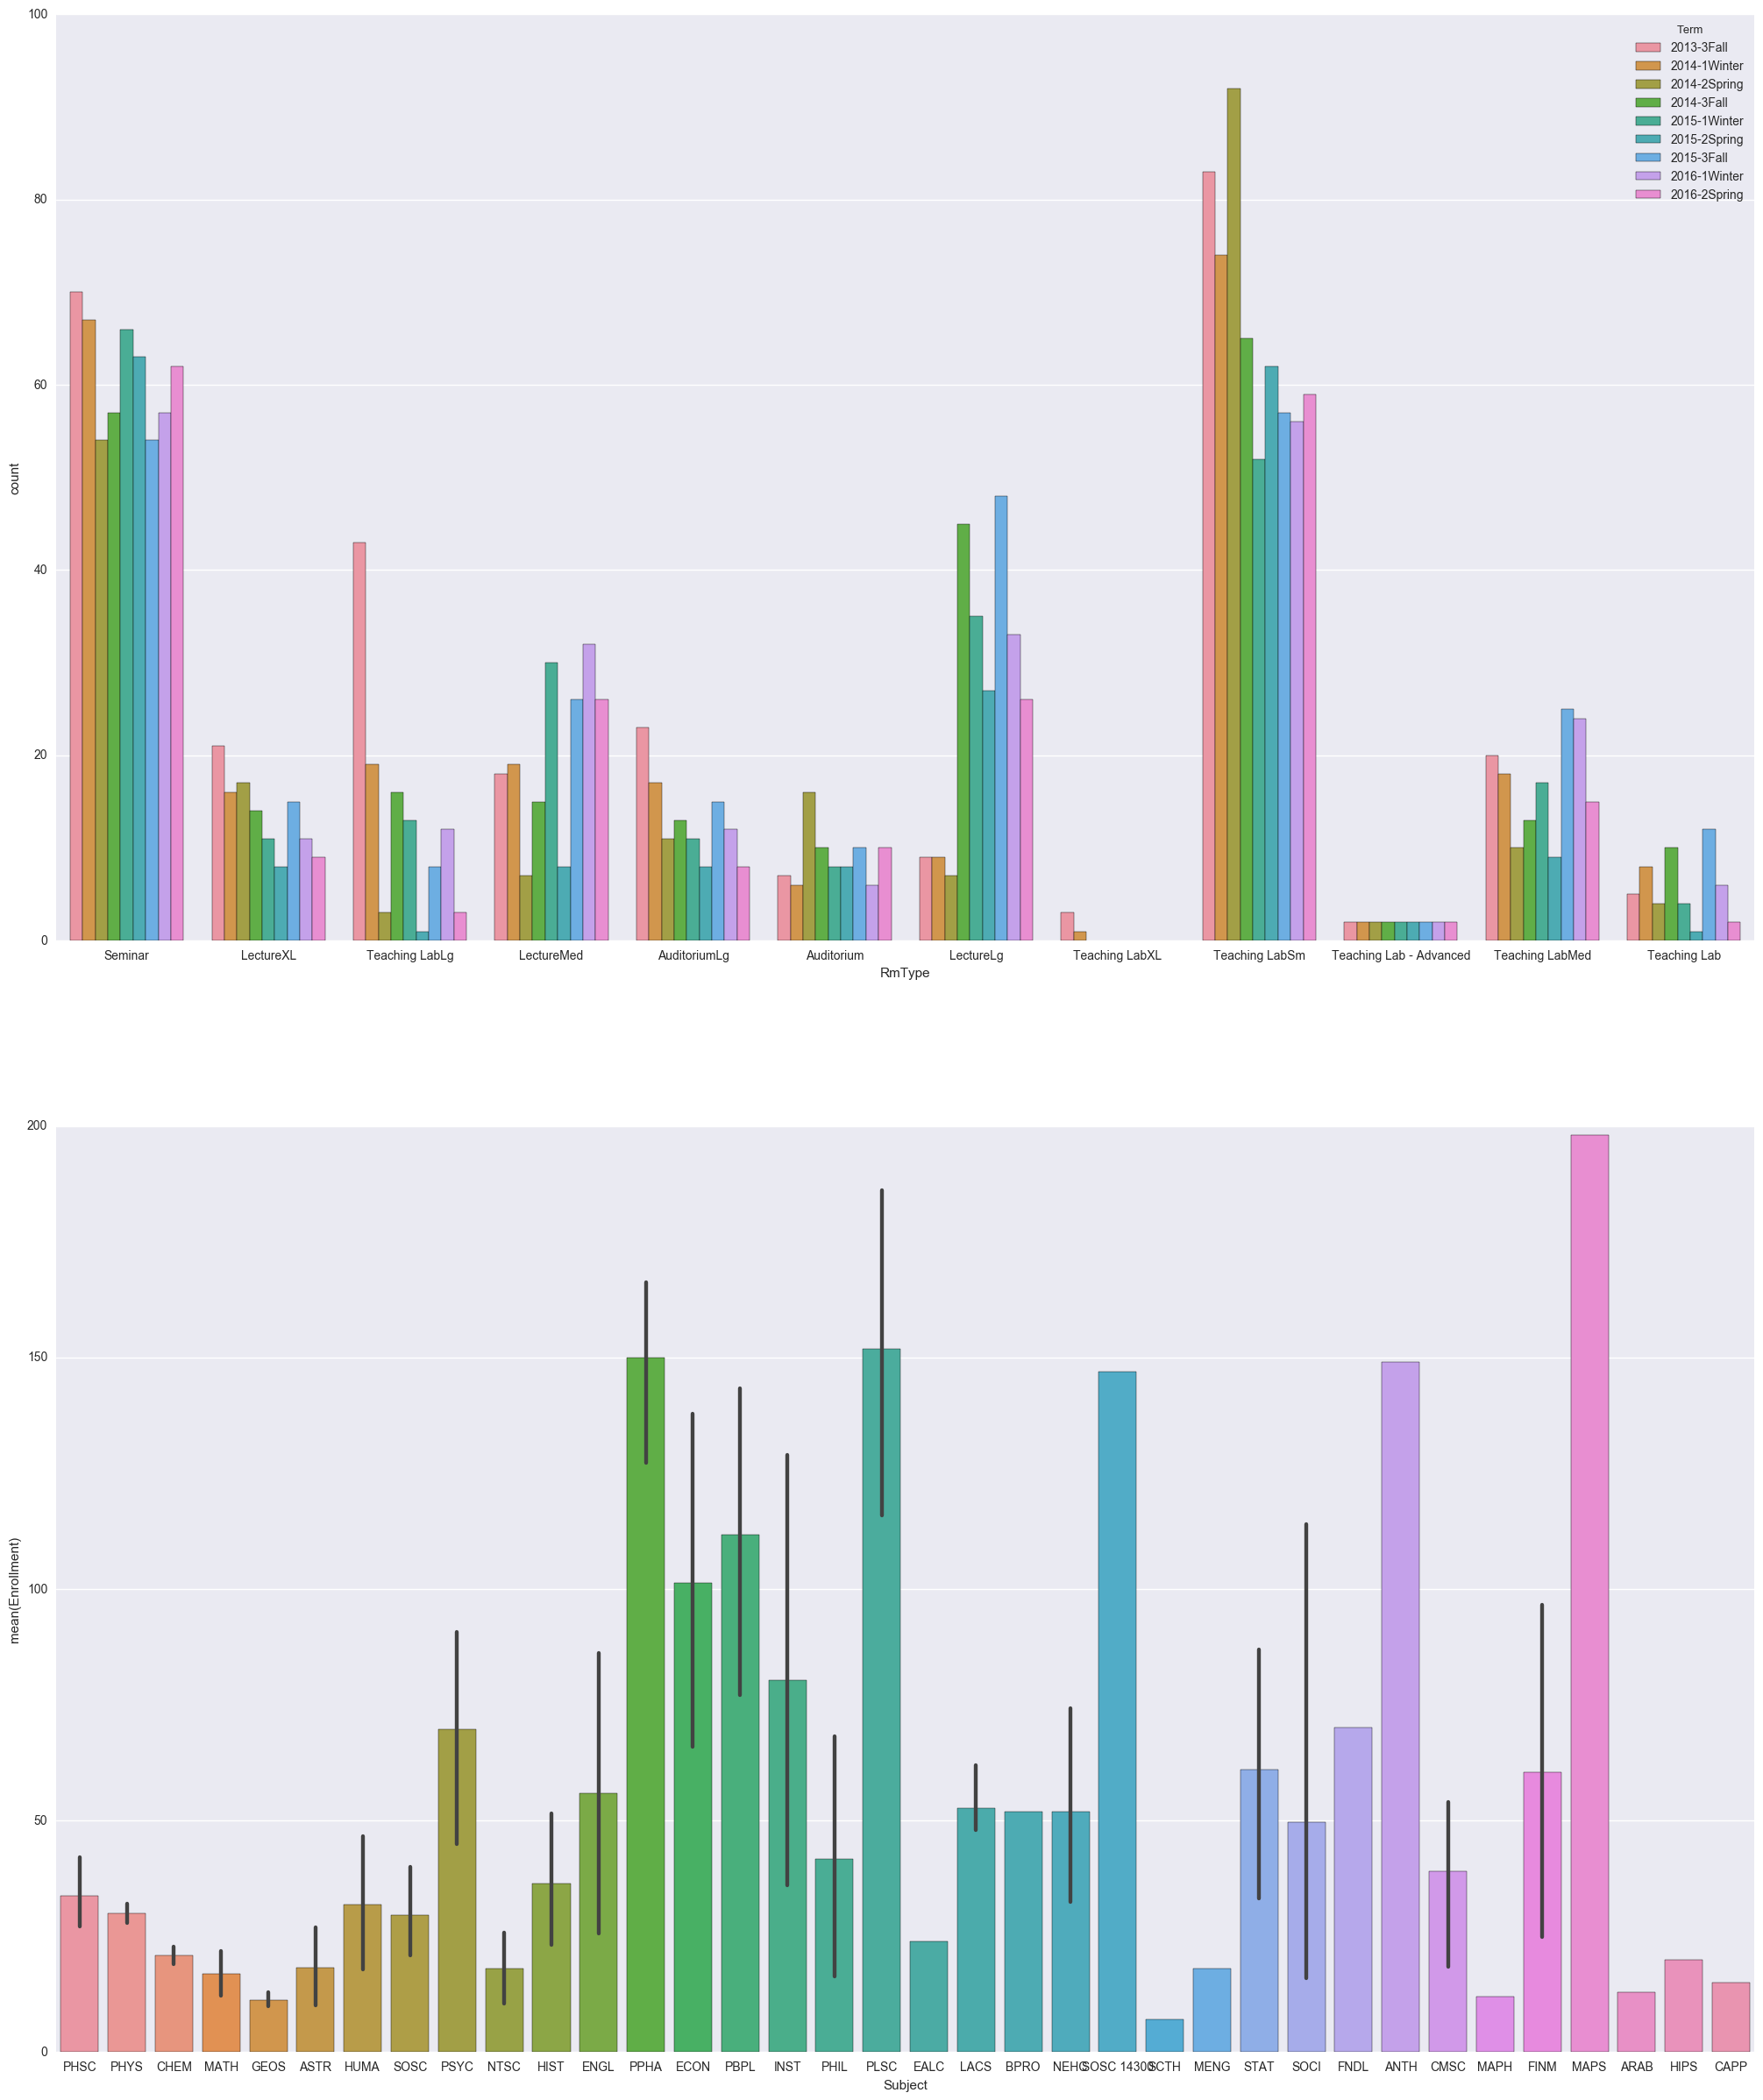

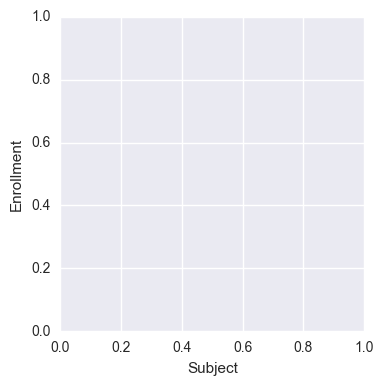

In [87]:
sns.set()
sns.set_context("notebook")
fig, axs = plt.subplots(2, sharex=False, figsize=(25, 30))

a = sns.countplot(x='RmType', hue= 'Term', data=data_CI, ax=axs[0])
b = sns.factorplot( x='Subject', y= 'Enrollment',kind='bar', data=data_CI, ax=axs[1])

#a.savefig("RmTerm.png")
#b.savefig("SubjectEnroll.png")


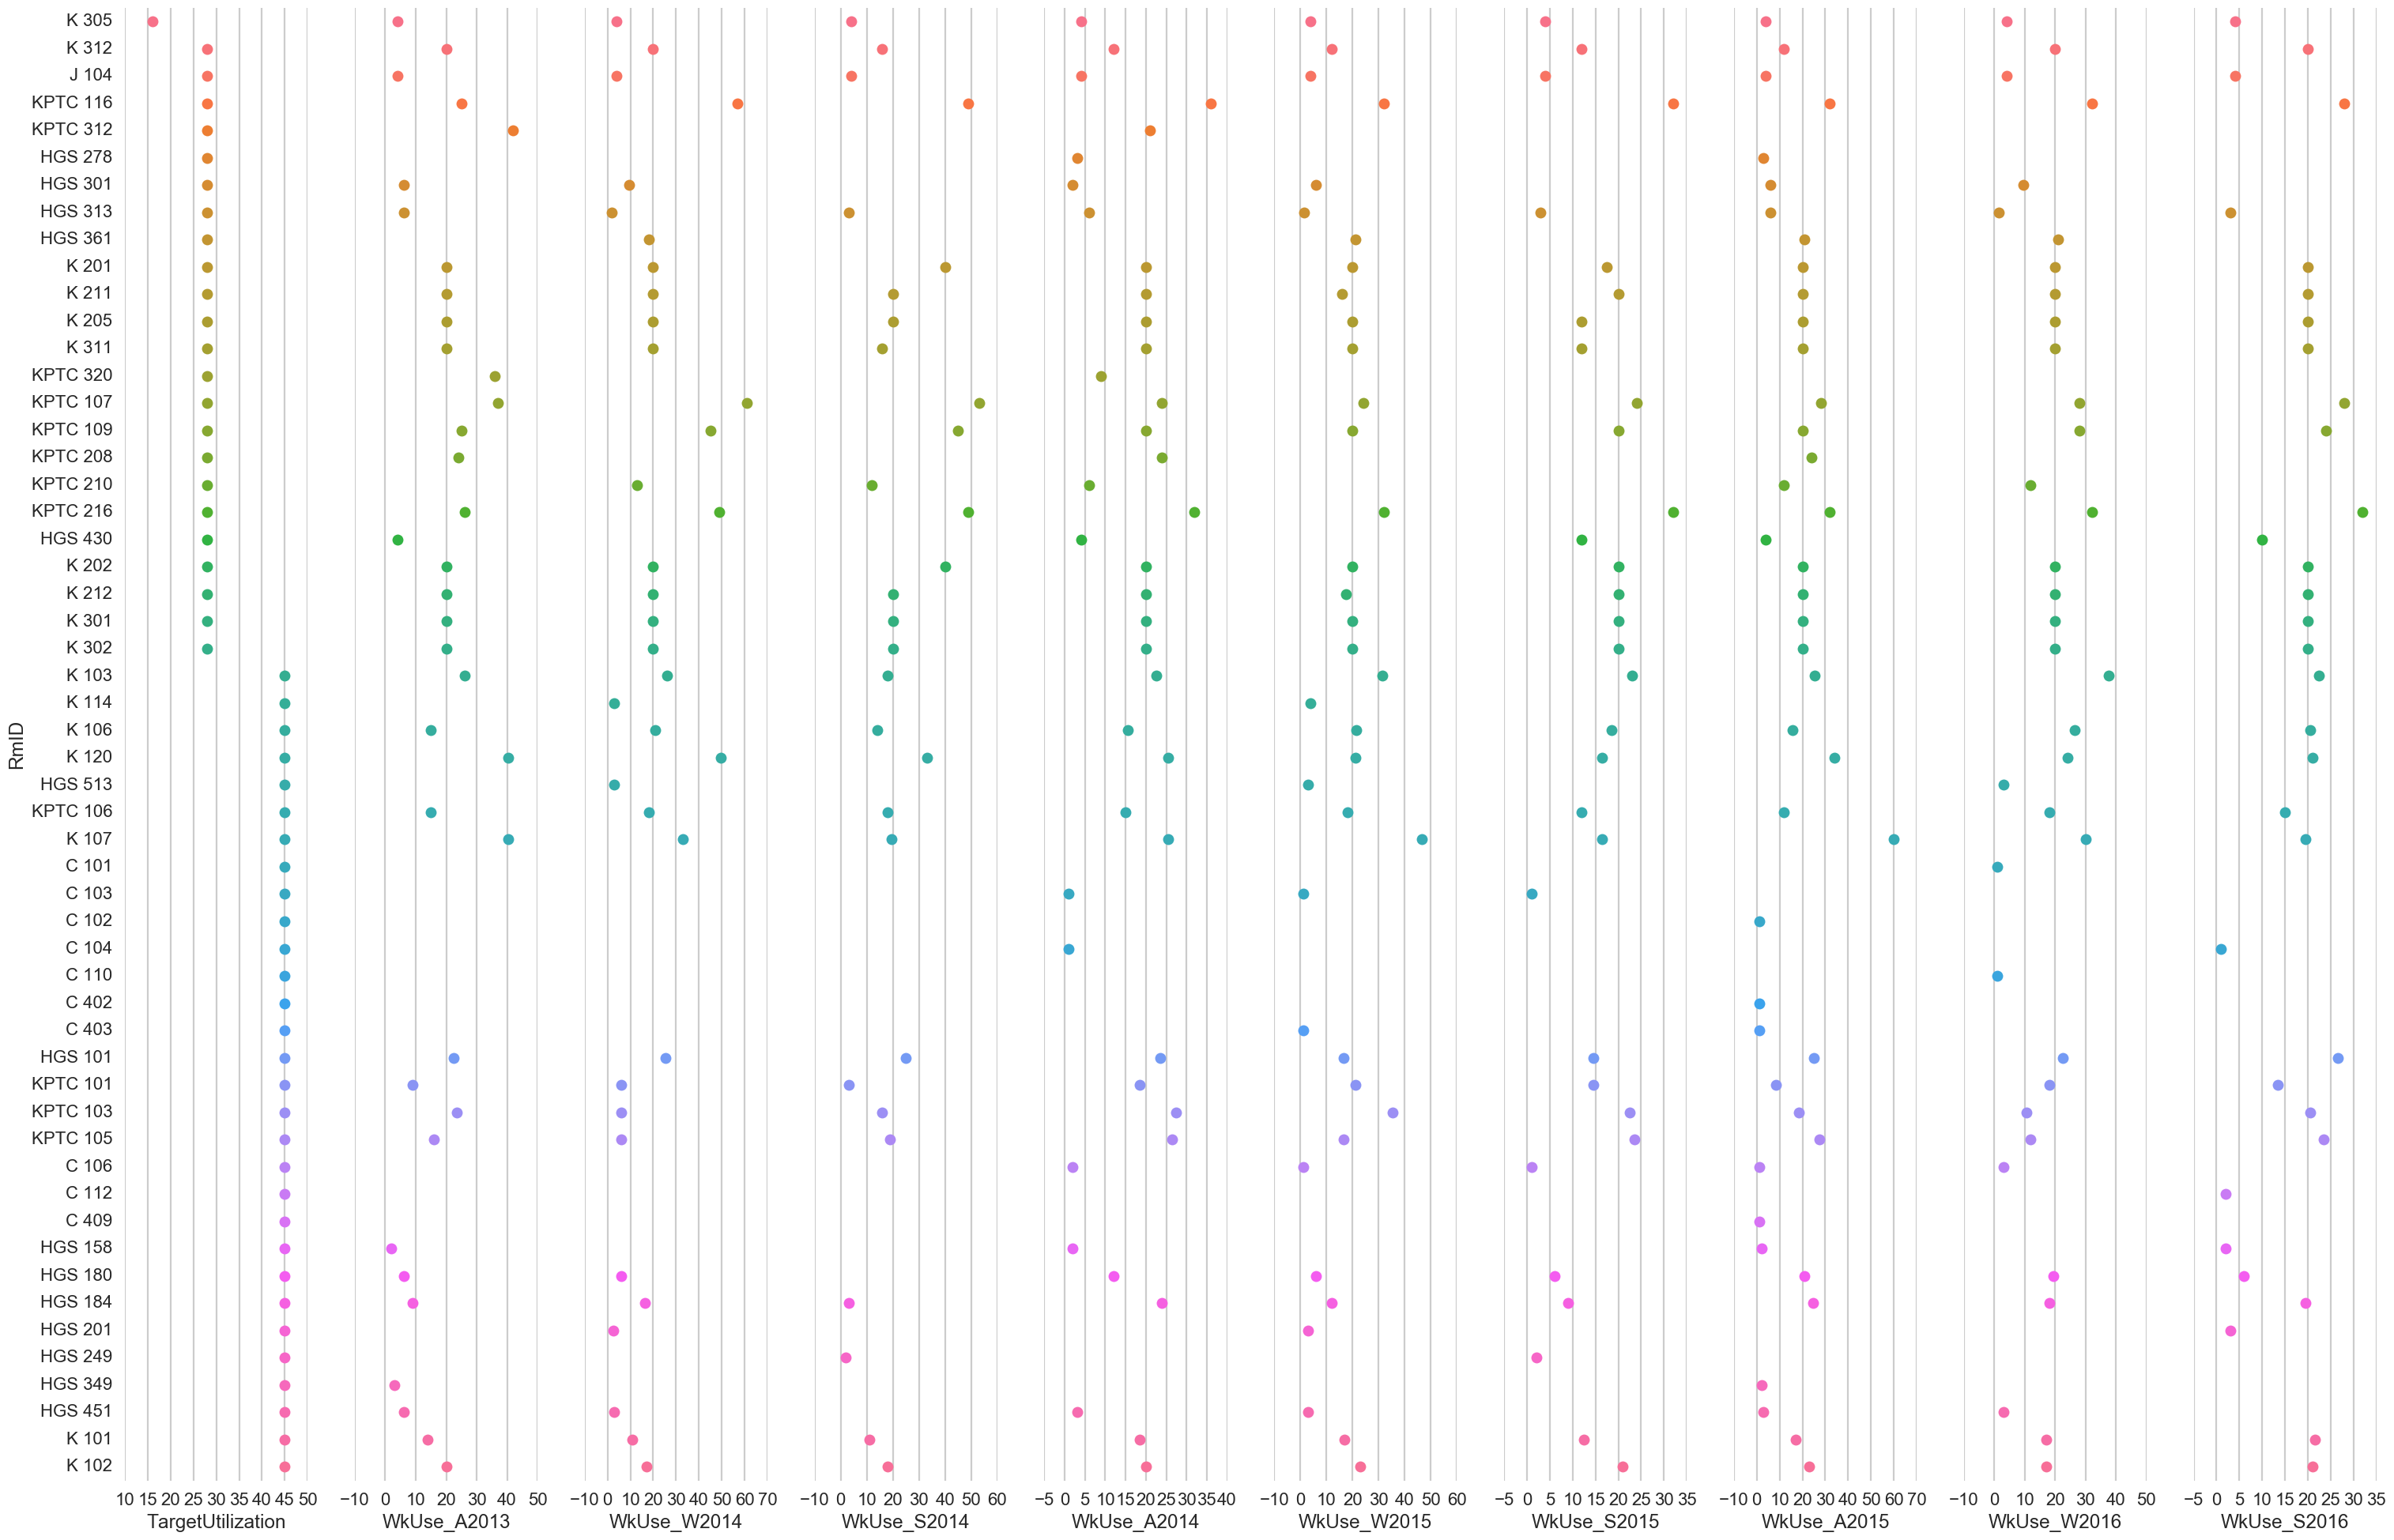

In [88]:
sns.set(style="whitegrid")
sns.set_context("poster")
g = sns.PairGrid(data_RI2.sort_values("TargetUtilization"),#, ascending=False),
                  x_vars=data_RI2.columns[[3,8,9,10,11,12,13,14,15,16]], y_vars=["RmID"], 
                  size=20, aspect=.15)

g.map(sns.stripplot, size=10
      , orient="h",
      palette="husl", edgecolor="gray")

sns.despine(left=True, bottom=True)

#data_RI_KPTC = data_RI[data_RI.Building == 'KPTC']
#sns.countplot(x='RmType', hue = 'Tech'  ,data=data_RI)

### Work

### Room Scenarios
- A. Current conditions
- B. Exhaustive List of Room Combos
      

In [89]:
#A Make combinations of the 12 roomtypes that fit into the five buildings
#Max size sq feet (SF) to play with in each building. Combos must add up to this: 
Max_SF_C = 4860
Max_SF_HGS = 8720
Max_SF_J = 1260 #building with large lab
Max_SF_K = 31260
Max_SF_KPTC = 18080
#TotalSqFt = Max_SF_C + Max_SF_HGS + Max_SF_J + Max_SF_K + Max_SF_KPTC
TotalSqFt = Max_SF_C + Max_SF_HGS + Max_SF_K + Max_SF_KPTC #not changing the buildling with the large lab.
print "TotalSqFt Available = ", TotalSqFt

# adds rmtypes and hrs required with the sf and target utilization hours
data_RT = pd.read_csv("RoomTypes.csv")
data_RI6 = pd.merge(data_RT, data_RI5, left_on=['RmType'], right_on=['RmType'], how='inner')

# figures out how many rms of each rmtype needed over the 10 yr growth
data_RI6['RoomsNeeded'] = np.ceil(data_RI6['WkUse_proj'] / data_RI6['TargetUtilization'])
data_RI6['SF_needed'] = data_RI6['RoomsNeeded'] * data_RI6['SF'] # calcs sf from that

print "Fixed SqFt for Room types = ", data_RI6['SF_needed'].sum()# requirement of sf for rooms to hit target hours
print "Flex SqFt = ", TotalSqFt - data_RI6['SF_needed'].sum() #sf left to work with
data_RI6



TotalSqFt Available =  62920
Fixed SqFt for Room types =  65390.0
Flex SqFt =  -2470.0


,RmType,TargetUtilization,RmCapacity,SF,Tech,WkUse,WkUse_proj,RoomsNeeded,SF_needed
0,TeachingLabXL,28,40,1800,1,96.0,170.069856,7.0,12600.0
1,TeachingLabSm,28,16,670,1,168.0,297.622248,11.0,7370.0
2,TeachingLabMed,28,20,840,1,148.0,262.191028,10.0,8400.0
3,TeachingLabLg,28,30,1260,1,71.0,125.780831,5.0,6300.0
4,TeachingLabAdLg,16,18,3000,1,4.0,7.086244,1.0,3000.0
5,Seminar,45,16,320,0,144.5,255.990565,6.0,1920.0
6,LectureXL,45,66,900,0,96.0,170.069856,4.0,3600.0
7,LectureMed,45,20,500,0,3.0,5.314683,1.0,500.0
8,LectureLg,45,35,700,0,1.0,1.771561,1.0,700.0
9,AuditoriumLg,45,250,5000,0,60.0,106.293660,3.0,15000.0


In [104]:
#Current Rooms in each building
Rm_Building = pd.crosstab(index=data_RI['RmType'], 
                            columns=data_RI['Building'],margins=True )

Rm_Building2 = Rm_Building.reset_index()
Rm_Building.sort(columns=None, axis=0, ascending=False, inplace=True)
Rm_Building

C:\Users\kzellner\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(....) is deprecated, use sort_index(.....)


Building,C,HGS,J,K,KPTC,All
RmType,,,,,,
TeachingLabXL,0,1,0,4,0,5
TeachingLabSm,0,0,0,1,6,7
TeachingLabMed,0,4,0,5,3,12
TeachingLabLg,0,0,1,6,2,9
TeachingLabAdLg,0,0,0,1,1,2
Seminar,3,8,0,5,1,17
LectureXL,0,1,0,0,4,5
LectureMed,5,0,0,0,4,9
LectureLg,2,0,0,0,0,2


In [107]:
RoomsNeeded = []
for iRm in range(np.shape(data_RI6)[0]):
   if data_RI6['RmType'].tolist()[iRm] != 'LectureLg':
   #print data_RI6['RmType'].tolist()[iRm], data_RI6['RoomsNeeded'].tolist()[iRm]
       RoomsNeeded = RoomsNeeded + [data_RI6['RmType'].tolist()[iRm]] * data_RI6['RoomsNeeded'].tolist()[iRm]
  

print "we will try to fit exactly ", len(RoomsNeeded), " rooms into the buildings"    
print RoomsNeeded

we will try to fit exactly  51  rooms into the buildings
['TeachingLabXL', 'TeachingLabXL', 'TeachingLabXL', 'TeachingLabXL', 'TeachingLabXL', 'TeachingLabXL', 'TeachingLabXL', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabMed', 'TeachingLabMed', 'TeachingLabMed', 'TeachingLabMed', 'TeachingLabMed', 'TeachingLabMed', 'TeachingLabMed', 'TeachingLabMed', 'TeachingLabMed', 'TeachingLabMed', 'TeachingLabLg', 'TeachingLabLg', 'TeachingLabLg', 'TeachingLabLg', 'TeachingLabLg', 'TeachingLabAdLg', 'Seminar', 'Seminar', 'Seminar', 'Seminar', 'Seminar', 'Seminar', 'LectureXL', 'LectureXL', 'LectureXL', 'LectureXL', 'LectureMed', 'AuditoriumLg', 'AuditoriumLg', 'AuditoriumLg', 'Auditorium', 'Auditorium', 'Auditorium']


C:\Users\kzellner\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [111]:
#B Exhaustive list of room combo 
# record only unique permutations: 

Max_SF_C = 4860
Max_SF_HGS = 8720
Max_SF_J = 1260
Max_SF_K = 31260
Max_SF_KPTC = 18080


Rm_Needed = data_RI6[['RmType', 'RoomsNeeded','Tech']]
Buildings = ['C','HGS','J','K','KPTC']

DF1 = pd.merge(Rm_Building2, Rm_Needed, left_on = ['RmType'], right_on = ['RmType']) #adds rms needed and tech
DF2 = pd.merge(DF1, data_RI6[['RmType','SF']], left_on = ['RmType'], right_on = ['RmType']) # adds sf to dataframe


# for each buildling calculate how much tech and non tech space available to change. 
# calculate SF and number of rooms for tech / non tech space. 
TechCount_SF_dict = dict.fromkeys(Buildings,0)
TechCount_RM_dict = dict.fromkeys(Buildings,0)

DF2['RoomsLeft'] = DF2['RoomsNeeded']

for iBuild in Buildings: 
    #print iBuild
    DF2['RoomsLeft'] = DF2['RoomsLeft'] - DF2[iBuild]
    #print DF1['RoomsLeft']
    List = [0,0]
    List2 = [0,0]
    for i in range(np.shape(DF2)[0]):
        if DF2['RoomsLeft'][i] < 0: 
            #print DF2['RoomsLeft'][i], DF2['SF'][i], DF2['Tech'][i]
            if DF2['Tech'][i] == 1:
                List[0] = List[0] + np.abs(DF2['RoomsLeft'][i]) * DF2['SF'][i]
                List2[0] = List2[0] + np.abs(DF2['RoomsLeft'][i])
            if DF2['Tech'][i] == 0:    
                List[1] = List[1] + np.abs(DF2['RoomsLeft'][i]) * DF2['SF'][i]
                List2[1] = List2[1] + np.abs(DF2['RoomsLeft'][i])
            TechCount_SF_dict[iBuild] = List
            TechCount_RM_dict[iBuild] = List2
        DF2['RoomsLeft'][i] = max(0, DF2['RoomsLeft'][i])

# J isn't being modified as specified in previous steps
TechCount_SF_dict['J'] = [0,0]
TechCount_RM_dict['J'] = [0,0]
print "[tech,nontech]"
print "SF: ", TechCount_SF_dict
print "Rms: ", TechCount_RM_dict
    
#print DF2


RoomsToBuild = []

for i in range(np.shape(DF2)[0]):
    if DF2['RoomsLeft'][i] > 0:
        print DF2['RoomsLeft'][i], DF2['RmType'][i], DF2['SF'][i], DF2['Tech'][i]
        RoomsToBuild = RoomsToBuild + [DF2['RmType'][i]] * DF2['RoomsLeft'][i]
 
      
#finds all unique arragements of rooms(removed duplicates)
class Solution(object):
    def permute_unique(self, nums):
        perms = [[]]
        for n in nums:
            new_perm = []
            for perm in perms:
                for i in range(len(perm) + 1):
                    new_perm.append(perm[:i] + [n] + perm[i:])
                    # handles duplication
                    if i < len(perm) and perm[i] == n: break
            perms = new_perm
        return perms

s = Solution()

print " There are ", len(s.permute_unique(RoomsToBuild)), " combinations to try"
Combos = s.permute_unique(RoomsToBuild)



C:\Users\kzellner\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[tech,nontech]
SF:  {'K': [2520.0, 1600.0], 'C': [0, 2700.0], 'J': [0, 0], 'KPTC': [7200.0, 3220.0], 'HGS': [0, 1600.0]}
Rms:  {'K': [2.0, 5.0], 'C': [0, 5.0], 'J': [0, 0], 'KPTC': [5.0, 6.0], 'HGS': [0, 5.0]}
1.0 Auditorium 2000 0
2.0 AuditoriumLg 5000 0
4.0 TeachingLabSm 670 1
2.0 TeachingLabXL 1800 1
 There are  3780  combinations to try


C:\Users\kzellner\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


###  Conclusions


In [115]:
# Combos has all possible combinations for the areas we are going to change: 

Rooms = {}

# Shows for each room type we need to change/build how much space it takes and if it is tech/nontech.  
Rooms['TeachingLabXL'] = [1, 1800]
Rooms['TeachingLabSm'] = [1, 670]
Rooms['AuditoriumLg'] = [0, 5000]
Rooms['Auditorium'] = [0, 2000]

print Rooms
print Combos[0]
print Buildings 
print TechCount_SF_dict
print TechCount_RM_dict

#makes df to store results & scores
Results = pd.DataFrame(columns=['Combo','Price','Fit'])
Results['Combo'] = Combos
Results.head()
# Q1: did it fit? 
# Q2: price? 

# Costs to change 
TtoNT = 8000 #Technical to non technical
NTtoT = 20000 #Non-technical to technical
BaseCost = 5000 #Add or subtract wall- standard fee per change

def Build_B_seq():
    B_seq = []
    for iBuild in TechCount_SF_dict.keys(): 
        B_seq = B_seq + TechCount_SF_dict[iBuild]
    return B_seq


#calculates how well each arragment of rooms will do
for i in range(len(Combos)):
    B = Build_B_seq()
    Tech_NonTech = [0,0]
    NumAdded = 0
    current = 0
    advance = 0
    for iC in Combos[i]: #loops through each room to place
        advance = 0 #flags if it is not yet placed
        if current < 10: 
            #print B, Rooms[iC][1]
            while advance == 0 and current != 10: #can't move on to next room til its placed
                if B[current] - Rooms[iC][1] > 0: # makes sure there is space left
                    B[current] = B[current] - Rooms[iC][1] # place and adjust space free numbers
                    if current%2 == Rooms[iC][0]: #if you are converting tech/nontech, or vice versa:  
                        Tech_NonTech[current%2] = Tech_NonTech[current%2] + 1#counts the number of tech to non-tech
                    NumAdded = NumAdded + 1 #counts rooms able to be added from this 
                    advance = 1 #flags room as no longer needing to be placed
                else:
                    current = current + 1 #doesnt fit? try next building
                    advance = 0 #keeps this at 0 so it doesnt move on
    
    Results['Fit'][i] = NumAdded
    Results['Price'][i] = Tech_NonTech[0]*TtoNT + Tech_NonTech[1]*NTtoT + NumAdded*BaseCost  #Calculates cost

    
print Results.head()
MAXrooms = Results['Fit'].max()
MINprice = Results['Price'].min()

#print "max global rooms that fit:", MAXrooms
#print "min global price:", MINprice

temp = Results.ix[Results['Fit'] == MAXrooms].reset_index()
MAXrooms_price = temp['Price'].min()

temp = Results.ix[Results['Price'] == MINprice].reset_index()
MINprice_rooms = temp['Fit'].max()
print ""
print "There are two ways to optimize:"
print "1. You can fit ", MAXrooms, " out of 10 rooms, and pay ",  MAXrooms_price

print "2. You can fit ", MINprice_rooms, " out of 10 rooms, and pay ",  MINprice

print "if you can fit all 10 rooms then you will be able to fit the next 6 years at 10% growth per year."



{'AuditoriumLg': [0, 5000], 'TeachingLabSm': [1, 670], 'Auditorium': [0, 2000], 'TeachingLabXL': [1, 1800]}
['TeachingLabXL', 'TeachingLabXL', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'TeachingLabSm', 'AuditoriumLg', 'AuditoriumLg', 'Auditorium']
['C', 'HGS', 'J', 'K', 'KPTC']
{'K': [2520.0, 1600.0], 'C': [0, 2700.0], 'J': [0, 0], 'KPTC': [7200.0, 3220.0], 'HGS': [0, 1600.0]}
{'K': [2.0, 5.0], 'C': [0, 5.0], 'J': [0, 0], 'KPTC': [5.0, 6.0], 'HGS': [0, 5.0]}
                                               Combo   Price Fit
0  [TeachingLabXL, TeachingLabXL, TeachingLabSm, ...   83000   7
1  [TeachingLabXL, TeachingLabSm, TeachingLabXL, ...   83000   7
2  [TeachingLabSm, TeachingLabXL, TeachingLabXL, ...   83000   7
3  [TeachingLabXL, TeachingLabSm, TeachingLabSm, ...  103000   7
4  [TeachingLabSm, TeachingLabXL, TeachingLabSm, ...  103000   7

There are two ways to optimize:
1. You can fit  8  out of 10 rooms, and pay  68000
2. You can fit  1  out of 10 rooms, and pay  13000
if 